In [22]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
%matplotlib inline

In [23]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [24]:
# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.
def similarityTransform(inPoints, outPoints):
  s60 = math.sin(60*math.pi/180)
  c60 = math.cos(60*math.pi/180)

  inPts = np.copy(inPoints).tolist()
  outPts = np.copy(outPoints).tolist()

  # The third point is calculated so that the three points make an equilateral triangle
  xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
  yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]

  inPts.append([np.int(xin), np.int(yin)])

  xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
  yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]

  outPts.append([np.int(xout), np.int(yout)])

  # Now we can use estimateRigidTransform for calculating the similarity transform.
  tform = cv2.estimateAffinePartial2D(np.array([inPts]), np.array([outPts]))
  return tform[0]

In [32]:
def normalizeImagesAndLandmarks(outSize, imIn, pointsIn):
    h, w = outSize

    # Corners of the eye in input image
    eyecornerSrc = [pointsIn[36], pointsIn[45]]

  # Corners of the eye in normalized image
    eyecornerDst = [(np.int(0.3 * w), np.int(h/3)), 
                  (np.int(0.7 * w), np.int(h/3))]

  # Calculate similarity transform
    tform = similarityTransform(eyecornerSrc, eyecornerDst)

  # Apply similarity transform to input image
    imOut = cv2.warpAffine(imIn, tform, (w, h))

  # reshape pointsIn from numLandmarks x 2 to numLandmarks x 1 x 2
    points2 = np.reshape(pointsIn, 
                      (pointsIn.shape[0], 1, pointsIn.shape[1]))

  # Apply similarity transform to landmarks
    pointsOut = cv2.transform(points2, tform)

  # reshape pointsOut to numLandmarks x 2
    pointsOut = np.reshape(pointsOut, 
                        (pointsIn.shape[0], pointsIn.shape[1]))
    return imOut, pointsOut

In [5]:
import faceBlendCommon as fbc
import dlib
import os

In [6]:
def readImagePaths(path):
    imagePaths = []
    for filePath in sorted(os.listdir(path)):
        fileExt = os.path.splitext(filePath)[1]
        if fileExt in [".jpg", ".jpeg"]:
            imagePaths.append(os.path.join(path, filePath))
    return imagePaths

In [40]:
shape_predictor = "../shape_predictor_68_face_landmarks.dat"
facedetector = dlib.get_frontal_face_detector()
landmarkdetector = dlib.shape_predictor(shape_predictor)
imagespaths = readImagePaths("presidents")
all_landmarkpoints = []
images = []
for i in imagespaths:
    img = cv2.imread(i)
    landmarkpoints = points = fbc.getLandmarks(facedetector, landmarkdetector, img)
    all_landmarkpoints.append(landmarkpoints)
    im = np.float32(img)/255.0
    images.append(im)

In [46]:
all_landmarkpoints

[[(360, 570),
  (367, 661),
  (376, 748),
  (389, 835),
  (418, 916),
  (467, 989),
  (529, 1054),
  (598, 1105),
  (682, 1119),
  (769, 1099),
  (839, 1045),
  (907, 979),
  (965, 906),
  (997, 829),
  (1008, 740),
  (1009, 653),
  (1013, 568),
  (433, 537),
  (471, 491),
  (527, 470),
  (587, 470),
  (647, 484),
  (740, 484),
  (798, 465),
  (860, 463),
  (917, 484),
  (951, 530),
  (692, 540),
  (691, 597),
  (690, 654),
  (689, 713),
  (605, 742),
  (645, 751),
  (689, 762),
  (732, 749),
  (774, 739),
  (502, 561),
  (537, 543),
  (573, 540),
  (610, 560),
  (573, 563),
  (538, 565),
  (779, 556),
  (816, 535),
  (852, 537),
  (887, 556),
  (851, 561),
  (815, 559),
  (525, 842),
  (576, 821),
  (639, 813),
  (690, 820),
  (737, 811),
  (799, 814),
  (850, 832),
  (801, 900),
  (740, 934),
  (690, 942),
  (638, 937),
  (576, 907),
  (539, 845),
  (640, 834),
  (690, 839),
  (737, 832),
  (835, 837),
  (738, 894),
  (690, 902),
  (639, 896)],
 [(328, 664),
  (338, 729),
  (350, 794

In [48]:
# Dimensions of output image
w = 600
h = 600

#8 Boundary points for Delaunay Triangulation
boundaryPts = fbc.getEightBoundaryPoints(h, w)

numImages = len(imagespaths)
numLandmarks = len(all_landmarkpoints[0])

# Variables to store normalized images and points.
imagesNorm = []
pointsNorm = []

#Initialize location of average points to 0s
pointsAvg = np.zeros((numLandmarks, 2), dtype=np.float32)

#warp Images and transform landmarks to outpit coordinate system, and find average of transformed landmarks
for i, img in enumerate(images):
    points = all_landmarkpoints[i]
    points = np.array(points)
    img, points = normalizeImagesAndLandmarks((h, w), img, points)
    #Calculate average landmarks locations
    pointsAvg = pointsAvg + (points/(1.0*numImages))
    
    #Append boundary points. Will be used in Delaunay Triangulation
    points = np.concatenate((points, boundaryPts), axis=0)
    
    pointsNorm.append(points)
    imagesNorm.append(img)

#Append bounday points to average points.
pointsAvg = np.concatenate((pointsAvg, boundaryPts), axis=0)

In [53]:
rect = (0, 0, w, h)
dt = fbc.calculateDelaunayTriangles(rect, pointsAvg)
output = np.zeros((h, w, 3), dtype=np.float)
for i in range(0, numImages):
    imWarp = fbc.warpImage(imagesNorm[i], pointsNorm[i], pointsAvg.tolist(), dt)
    output = output + (imWarp/numImages)
#output = output / numImages

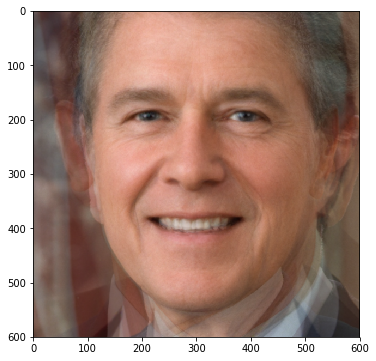

In [54]:
plt.imshow(output[:,:,::-1])